
# Step 1: 
Design and test a model architecture that can identify sequences of digits in an image.

Design and implement a deep learning model that learns to recognize sequences of digits. Train it using synthetic data first (recommended) or directly use real-world data (see step 2).

There are various aspects to consider when thinking about this problem:

    Your model can be derived from a deep neural net or a convolutional network.
    You could experiment sharing or not the weights between the softmax classifiers.
    You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

To help you develop your model, the simplest path is likely to generate a synthetic dataset by concatenating character images from notMNIST or MNIST. This can provide you with a quick way to run experiments. (Or you can go directly to the real-world dataset of Step 2.)

In order to produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

Here is for example a published baseline model on this problem (video).

Report:

    What approach did you take in coming up with a solution to this problem?
    What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)
    How did you train your model? Did you generate a synthetic dataset (if so, explain how)?


# Step 2: 
Train a model on a realistic dataset.

Once you have settled on a good architecture, you can train your model on real data. In particular, the SVHN dataset is a good large scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to do well.

Report:

    How does your model perform on a realistic dataset?
    What changes did you have to make, if any?


Resources:
- [a solution](https://github.com/potterhsu/SVHNClassifier)
- [solution with notebooks](https://github.com/DerrickChi/ML-svhn/)
- [dataset](http://ufldl.stanford.edu/housenumbers/)
- [RCNN paper](https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/2B_004.pdf)
- [Goodfellow on SVHN](https://arxiv.org/pdf/1312.6082.pdf)

### Visualize images

In [1]:
IMAGE_PATH = './TrainSVHN/train/'

In [2]:
import  os
import  numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
image_names = os.listdir(IMAGE_PATH)

image_names = [IMAGE_PATH + im for im in image_names if im.split('.')[-1] == 'png']
len(image_names)

33402

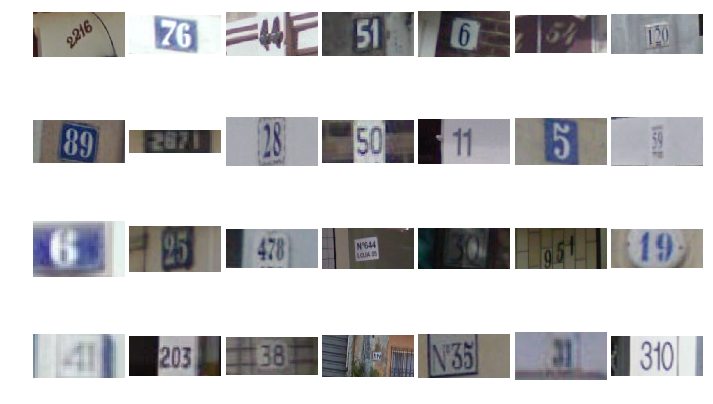

In [196]:
rand_show = 28
rand_images = np.random.choice(image_names, size=rand_show, replace=False)
plt.figure(figsize=(12,8))
for i,img in enumerate(rand_images):
    plt.subplot(4,7,1 + i)
    plt.imshow(plt.imread(img));
    plt.axis('off')
plt.subplots_adjust(wspace=.05, hspace=-.05)
plt.show()

### Read labels from matlab

In [4]:
LABELS = './TrainSVHN/train/digitStruct.mat'

In [5]:
from tqdm import tqdm
import h5py

In [6]:
def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

In [7]:
labels = h5py.File(LABELS, 'r')


100%|██████████| 33402/33402 [03:15<00:00, 170.98it/s]


In [8]:
len(pics), len(boxes), boxes[0].keys()

(33402, 33402, dict_keys(['height', 'label', 'left', 'top', 'width']))

### Create training dataset

In [10]:
from PIL import Image

In [217]:
nTrain = len(boxes)
maxLen = 5
defaultValue = 10
imgSize = 54
addCrop = .2

In [218]:
# init labels, data, indices to remove
labels = np.full((nTrain, maxLen), defaultValue, dtype=np.int)
train_arrays = np.zeros((nTrain, imgSize, imgSize, 3), dtype=np.int32)
indices_remove = []

for i in tqdm(range(nTrain)):
    # replace each of 5 labels with real digits
    nDigits = len(boxes[i]['label'])
    if nDigits <= maxLen:
        for l in range(nDigits):
            labels[i,l] = boxes[i]['label'][l]
    else:
        # fill a list when more than 5 labels to remove later
        indices_remove.append(i)
    # read image
    image_path = IMAGE_PATH + pics[i]
    img = Image.open(image_path)
    # crop image by adding 20% if height and width of digits
    left = np.min(boxes[i]['left'])
    top = np.min(boxes[i]['top'])
    right = np.add(boxes[i]['left'], boxes[i]['width']).max()
    bottom = np.add(boxes[i]['top'], boxes[i]['height']).max()
    width = right - left
    height = bottom - top
    nW,nH = img.size
    cropped = img.crop((max(0, left - width*addCrop),
                        max(0, top - height*addCrop),
                        min(nW, right + width*addCrop),
                        min(nH, bottom + height*addCrop))
                      )
    # resized and add it to other images
    resized = cropped.resize((imgSize, imgSize))
    train_arrays[i,:,:,:] = np.array(resized)

100%|██████████| 33402/33402 [00:22<00:00, 1516.27it/s]


In [219]:
len(indices_remove)

1

In [220]:
train_arrays = np.delete(train_arrays, indices_remove, axis=0)
labels = np.delete(labels, indices_remove, axis=0)
train_arrays.shape,labels.shape

((33401, 54, 54, 3), (33401, 5))

##### Convert to black and white

In [221]:
index = 2033

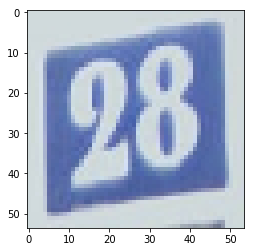

In [222]:
plt.imshow(train_arrays[index], );

In [223]:
train_arrays = np.dot(train_arrays[...,:3], [0.299, 0.587, 0.114])
train_arrays.shape

(33401, 54, 54)

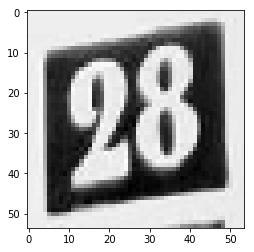

In [229]:
plt.imshow(train_arrays[index], cmap=plt.get_cmap('gray'));

##### Normalize images between 0 and 1

In [230]:
train_arrays.mean()

113.80381065891019

In [231]:
train_arrays = train_arrays / 255.
train_arrays.mean()

0.44628945356435068

##### Reshape

In [232]:
train_arrays.shape

(33401, 54, 54)

In [233]:
train_arrays = np.reshape(train_arrays, (train_arrays.shape[0], imgSize, imgSize, 1))

In [234]:
train_arrays.shape

(33401, 54, 54, 1)

##### Save arrays

In [235]:
import pickle

In [236]:
SAVE_TRAIN_ARRAYS = './svhn_train_arrays.pickle'
SAVE_TRAIN_LABELS = './svhn_train_labels.pickle'

In [237]:
with open(SAVE_TRAIN_ARRAYS, 'wb') as f:
    pickle.dump(train_arrays, f)
    
with open(SAVE_TRAIN_LABELS, 'wb') as f:
    pickle.dump(labels, f)